<table>
<tr>    
<td style="text-align: center">
<h1>1D Convnets Combined with RNNs for Sequence Processing</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td> 
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
</tr>
</table>
<h3><i>Welcome to the interactive lecture and exercises where you can check everything by yourself and experiment!</i></h3>

# Sequence Processing with 1D Convnets

Sequencial data are usually processed using recurrent neural networks (RNNs) of various kinds (e.g. GRU or LSTM), but sometimes we can also use convnets when the data sequence is not so important as the elements used in these sequences are. One of such problems is the IMDB sentiment classification task where the positive or negative classification depends more on the used words in the sentences than on the sequential relationships.

In [1]:
import tensorflow as tf
import keras
print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 2.8.0
Keras version: 2.8.0


In [2]:
# pip install tensorflow-gpu
# https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    
tf.device("/gpu:0")
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Set up the model directory for saving the trained models

In [3]:
import os

# The path to store trained models
models_dir = 'C:/ml/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

## Definition of plotting functions

First, let's define plotting functions that will be used to chart the plots of the achieved results:

In [4]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

#def plt_inline():
#    rc = plt.rcParams.copy()
#    %matplotlib inline
#    plt.rcParams.update(rc)

def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()
    
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()
    
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

## Implementing a 1D convnet

In Keras, we use a 1D convnet via the `Conv1D` layer, which takes as input 3D tensors with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, i.e., axis 1 in the input tensor.

1D convnets are structured in the same way as their 2D counter-parts and have a very similar interface to `Conv2D`. They consist of a stack of `Conv1D` and `MaxPooling1D` layers, eventually ending in either a global pooling layer (`GlobalMaxPooling1D`) or a `Flatten` layer, turning the 3D outputs into 2D outputs, allowing to add one or more `Dense` layers to the model, for classification or regression.

We can afford (taking into account the computing time) to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, while with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. Thus, we can easily afford 1D convolution windows of size 5, 7, 9, or even more.

Let's build a simple 2-layer 1D convnet applied to the IMDB sentiment classification task that we are already familiar with:

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


Now, let's define a 1D convnet for the IMDB dataset consisting of two 1D layers and a global 1D max-pooling layer:

In [6]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

modelIMDB2x1DGlobalPool = Sequential()
modelIMDB2x1DGlobalPool.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDB2x1DGlobalPool.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGlobalPool.add(layers.MaxPooling1D(5))
modelIMDB2x1DGlobalPool.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGlobalPool.add(layers.GlobalMaxPooling1D())
modelIMDB2x1DGlobalPool.add(layers.Dense(1))

modelIMDB2x1DGlobalPool.summary()

modelIMDB2x1DGlobalPool.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDB2x1DGlobalPool = modelIMDB2x1DGlobalPool.fit(x_train, y_train,
                                                        epochs=20,
                                                        batch_size=128,
                                                        validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

<Figure size 432x288 with 0 Axes>

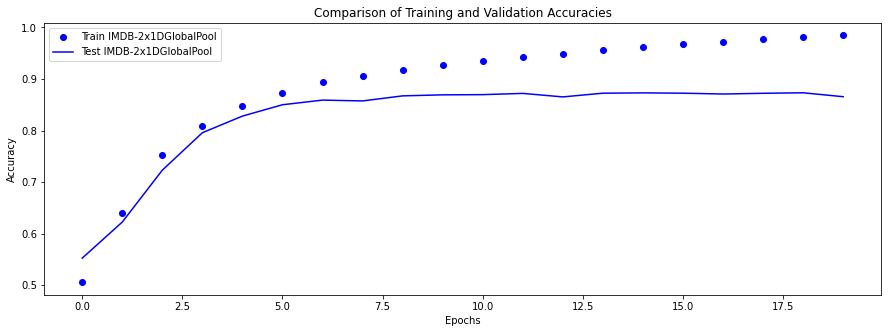

<Figure size 432x288 with 0 Axes>

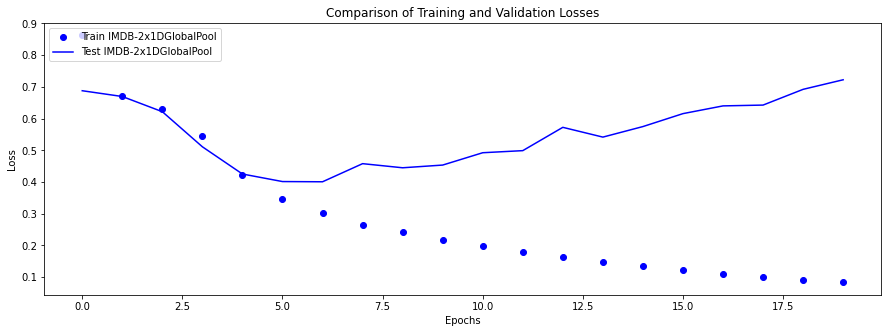

In [7]:
accIMDB2x1DGlobalPool = historyIMDB2x1DGlobalPool.history['acc']
val_accIMDB2x1DGlobalPool = historyIMDB2x1DGlobalPool.history['val_acc']
lossIMDB2x1DGlobalPool = historyIMDB2x1DGlobalPool.history['loss']
val_lossIMDB2x1DGlobalPool = historyIMDB2x1DGlobalPool.history['val_loss']

PlotAccuracyComparison(accIMDB2x1DGlobalPool, val_accIMDB2x1DGlobalPool, lab = 'IMDB-2x1DGlobalPool')
PlotLossComparison(lossIMDB2x1DGlobalPool, val_lossIMDB2x1DGlobalPool, lab = 'IMDB-2x1DGlobalPool')

The best training and validation results (in epochs 6 and 7) show that the validation accuracy is somewhat lower than that of the LSTM we used in the past, but runtime is much faster.

Now, we could re-train this model for the 6 epochs, after which this model returns the best results, and then run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

In [8]:
modelIMDB2x1DGlobalPool2 = Sequential()
modelIMDB2x1DGlobalPool2.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDB2x1DGlobalPool2.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGlobalPool2.add(layers.MaxPooling1D(5))
modelIMDB2x1DGlobalPool2.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGlobalPool2.add(layers.GlobalMaxPooling1D())
modelIMDB2x1DGlobalPool2.add(layers.Dense(1))

modelIMDB2x1DGlobalPool2.summary()

modelIMDB2x1DGlobalPool2.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
historyIMDB2x1DGlobalPool2 = modelIMDB2x1DGlobalPool2.fit(x_train, y_train,
                                                        epochs=6, # or 7 dependently on the network initialization
                                                        batch_size=128,
                                                        validation_split=0.2)

modelIMDB2x1DGlobalPool2.save(models_dir + 'IMDB_2x1DGlobalPool.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                

In [9]:
test_loss, test_acc = modelIMDB2x1DGlobalPool2.evaluate(x_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.4126 - acc: 0.8443


In [10]:
print('test_acc:', test_acc)

test_acc: 0.8442800045013428


As presented above, we achieved very quickly a quite reasonable and comparable to LSTM result for the test set!

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs - but that's still a fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem, where __order-sensitivity was key__ to produce good predictions. Let's see that 1D convnets behave really worse than RNNs on this problem (data), so not always we can use such solutions:

In [11]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

# You can download sample data from = 'http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/data/mpi_roof_2015-2021.zip'
data_dir = 'C:/ml/data/weather' # Unzip data and change this directory to yours
fname = os.path.join(data_dir, 'mpi_roof_2015-2021.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(lines[1:3])

print("Data attribute names for this dataset are:")
print(header)
print("Number of training examples: ", len(lines))

dim = len(header) - 1
float_data = np.zeros((len(lines), dim))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    if len(values) == 21:
        float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

['01.01.2015 00:20:00,1007.18,2.1,274.7,1.93,98.8,7.11,7.03,0.09,4.35,6.98,1271.28,0.65,1.16,129.3,0,0,0,0,0,14.26,434.2', '01.01.2015 00:30:00,1007.17,2.08,274.67,1.91,98.8,7.1,7.01,0.09,4.34,6.96,1271.4,0.46,1.64,134.1,0,0,0,0,0,14.27,435.8']
Data attribute names for this dataset are:
['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)', 'rain (mm)', 'raining (s)', 'SWDR (W/m˛)', 'PAR (µmol/m˛/s)', 'max. PAR (µmol/m˛/s)', 'Tlog (degC)', 'CO2 (ppm)']
Number of training examples:  332694


In [12]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

modelTemp2x1DGlobalPool = Sequential()
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
modelTemp2x1DGlobalPool.add(layers.MaxPooling1D(3))
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGlobalPool.add(layers.MaxPooling1D(3))
modelTemp2x1DGlobalPool.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGlobalPool.add(layers.GlobalMaxPooling1D())
modelTemp2x1DGlobalPool.add(layers.Dense(1))

modelTemp2x1DGlobalPool.compile(optimizer=RMSprop(), loss='mae')

historyTemp2x1DGlobalPool = modelTemp2x1DGlobalPool.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


modelTemp2x1DGlobalPool.save(models_dir + 'Temp-2x1DGlobalPool.h5')

Epoch 1/20
500/500 [==============================] - 22s 43ms/step - loss: 0.4495 - val_loss: 0.5036
Epoch 2/20
500/500 [==============================] - 25s 50ms/step - loss: 0.3813 - val_loss: 0.4887
Epoch 3/20
500/500 [==============================] - 25s 49ms/step - loss: 0.3541 - val_loss: 0.4885
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.3359 - val_loss: 0.4819
Epoch 5/20
500/500 [==============================] - 22s 45ms/step - loss: 0.3206 - val_loss: 0.4883
Epoch 6/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3109 - val_loss: 0.5008
Epoch 7/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3036 - val_loss: 0.4842
Epoch 8/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2948 - val_loss: 0.4791
Epoch 9/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2874 - val_loss: 0.4924
Epoch 10/20
500/500 [==============================] - 24s 48ms/step - loss: 0.283

Here are our training and validation Mean Absolute Errors:

<Figure size 432x288 with 0 Axes>

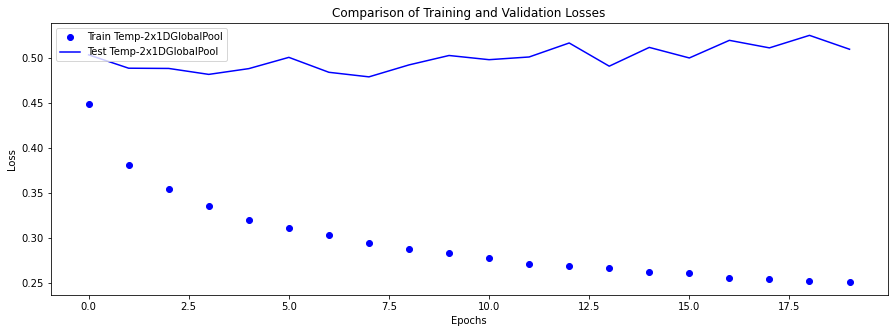

In [13]:
lossTemp2x1DGlobalPool = historyTemp2x1DGlobalPool.history['loss']
val_lossTemp2x1DGlobalPool = historyTemp2x1DGlobalPool.history['val_loss']

PlotLossComparison(lossTemp2x1DGlobalPool, val_lossTemp2x1DGlobalPool, lab = 'Temp-2x1DGlobalPool')

As expected, the validation MAE stays in the low 0.40s. We cannot even beat our common-sense baseline using this small convnet. Again, this is because our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. towards the beginning, towards the end). Since more recent datapoints should be interpreted differently from older datapoints in the case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an issue on IMDB because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN. This is especially beneficial when dealing with very long sequences (e.g. with thousands of steps) that could not realistically be processed with RNNs. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN (e.g. GRU or LSTM) part of the network.

This technique (1D convnet + RNN) is not seen very often in research papers and practical applications possibly because it is not very well known. It is very effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data generator) or look at high-resolution time-series (by decreasing the `step` parameter of the generator). Here, we will choose (somewhat arbitrarily) to use a `step` twice smaller, resulting in twice longer time-series, where the weather data is being sampled at a rate of one point per 30 minutes.

In [14]:
# This was previously set to 6 (one point per hour), now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [15]:
modelTemp2x1DGRU = Sequential()
modelTemp2x1DGRU.add(layers.Conv1D(32, 5, activation='relu',
                     input_shape=(None, float_data.shape[-1])))
modelTemp2x1DGRU.add(layers.MaxPooling1D(3))
modelTemp2x1DGRU.add(layers.Conv1D(32, 5, activation='relu'))
modelTemp2x1DGRU.add(layers.GRU(32, dropout=0.05, recurrent_dropout=0.05))
modelTemp2x1DGRU.add(layers.Dense(1))

modelTemp2x1DGRU.summary()

modelTemp2x1DGRU.compile(optimizer=RMSprop(), loss='mae')
historyTemp2x1DGRU = modelTemp2x1DGRU.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

modelTemp2x1DGRU.save(models_dir + 'Temp-2x1DGRU.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 32)          3392      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,913
Trainable params: 14,913
Non-trainable params: 0
__________________________________________________

<Figure size 432x288 with 0 Axes>

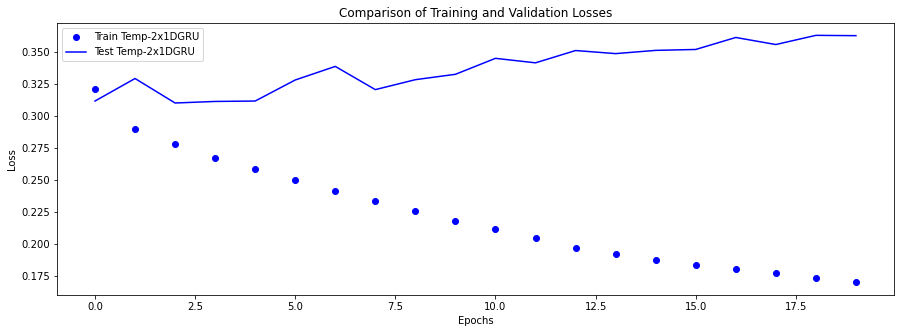

<Figure size 432x288 with 0 Axes>

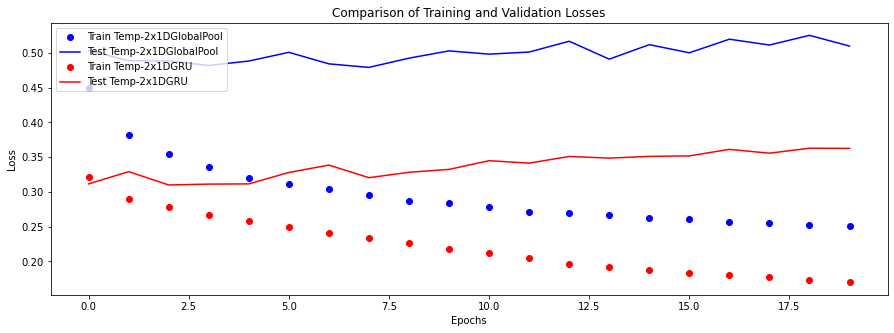

In [16]:
lossTemp2x1DGRU = historyTemp2x1DGRU.history['loss']
val_lossTemp2x1DGRU = historyTemp2x1DGRU.history['val_loss']

PlotLossComparison(lossTemp2x1DGRU, val_lossTemp2x1DGRU, lab = 'Temp-2x1DGRU')

PlotTwoLossComparison(lossTemp2x1DGlobalPool, val_lossTemp2x1DGlobalPool, lossTemp2x1DGRU, val_lossTemp2x1DGRU, lab1 = 'Temp-2x1DGlobalPool', lab2 = 'Temp-2x1DGRU')

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is looking at least at twice more data in the same time, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

Let's try to apply this approach to IMDB dataset as well:

In [17]:
modelIMDB2x1DGRU = Sequential()
modelIMDB2x1DGRU.add(layers.Embedding(max_features, 128, input_length=max_len))
modelIMDB2x1DGRU.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGRU.add(layers.MaxPooling1D(5))
modelIMDB2x1DGRU.add(layers.Conv1D(32, 7, activation='relu'))
modelIMDB2x1DGRU.add(layers.GRU(32, dropout=0.05, recurrent_dropout=0.05))
modelIMDB2x1DGRU.add(layers.Dense(1))

modelIMDB2x1DGRU.summary()

modelIMDB2x1DGRU.compile(optimizer=RMSprop(learning_rate=1e-4),
                         loss='binary_crossentropy',
                         metrics=['acc'])
historyIMDB2x1DGRU = modelIMDB2x1DGRU.fit(x_train, y_train,
                                          epochs=6, # or 7 dependently on the network initialization
                                          batch_size=128,
                                          validation_split=0.2)

modelIMDB2x1DGRU.save(models_dir + 'IMDB_2x1DGRU.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_9 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 92, 32)            7200      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                      

<Figure size 432x288 with 0 Axes>

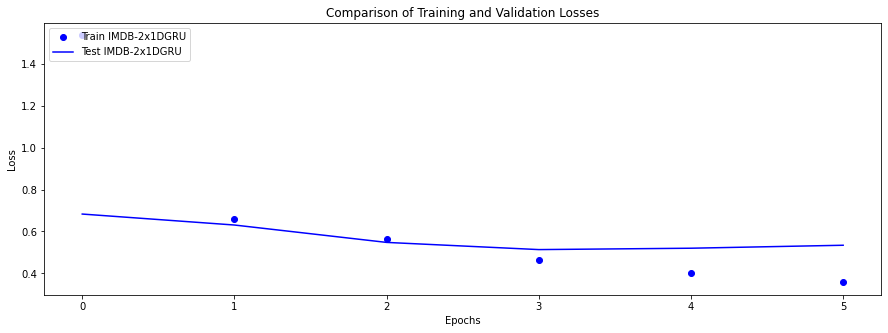

<Figure size 432x288 with 0 Axes>

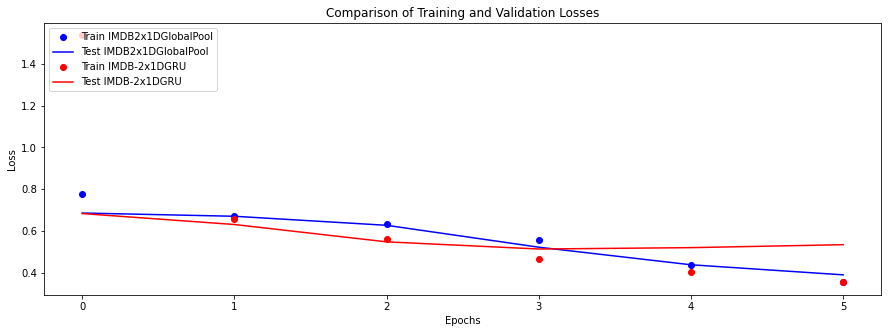

In [18]:
lossIMDB2x1DGRU = historyIMDB2x1DGRU.history['loss']
val_lossIMDB2x1DGRU = historyIMDB2x1DGRU.history['val_loss']

PlotLossComparison(lossIMDB2x1DGRU, val_lossIMDB2x1DGRU, lab = 'IMDB-2x1DGRU')

lossIMDB2x1DGlobalPool2 = historyIMDB2x1DGlobalPool2.history['loss']
val_lossIMDB2x1DGlobalPool2 = historyIMDB2x1DGlobalPool2.history['val_loss']

PlotTwoLossComparison(lossIMDB2x1DGlobalPool2, val_lossIMDB2x1DGlobalPool2, lossIMDB2x1DGRU, val_lossIMDB2x1DGRU, lab1 = 'IMDB2x1DGlobalPool', lab2 = 'IMDB-2x1DGRU')

## Wrapping up

Here's what you can take away:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets can perform well for processing some groups of temporal patterns where the sequence is not a key feature, e.g. for sentiment classification. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, while 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before a RNN, shortening the sequences and extracting useful representations for the RNN to process.
* Additionaly we can use 1D convolution with dilated kernels.